# EDMD-DL Tests on Duffing Oscillator

## Train the Model

Import necessary modules

In [1]:
import sys
sys.path.append('..')
import importlib
import KoopmanDL as kdl
import torch
import matplotlib.pyplot as plt
# importlib.reload(kdl)

CUDA is available. GPU is being used.
Project root dir is set to: /home/yxqian/code/deep_learning/MyKoopmanDL


Generate the data set

In [2]:
alpha = 1.0
beta = -1.0
delta = 0.5
dt = 1e-3
n_init = 1300
traj_len = 10
traj_t_step = 0.25
x_min = -2
x_max = 2
seed = 0
n_train = 10000
n_valid = 3000

duffing = kdl.DuffingOscillator(alpha, beta, delta)
flowmap = kdl.ForwardEuler(dt)
data_x_all = flowmap.generate_traj_data(duffing, n_init, traj_len, traj_t_step, x_min, x_max, seed)
data_y_all = flowmap.generate_next_data(duffing, data_x_all, traj_t_step)
dataset = kdl.DataSet(data_x_all, data_y_all)
data_train, data_valid = dataset.split(n_train)

Visualize train data

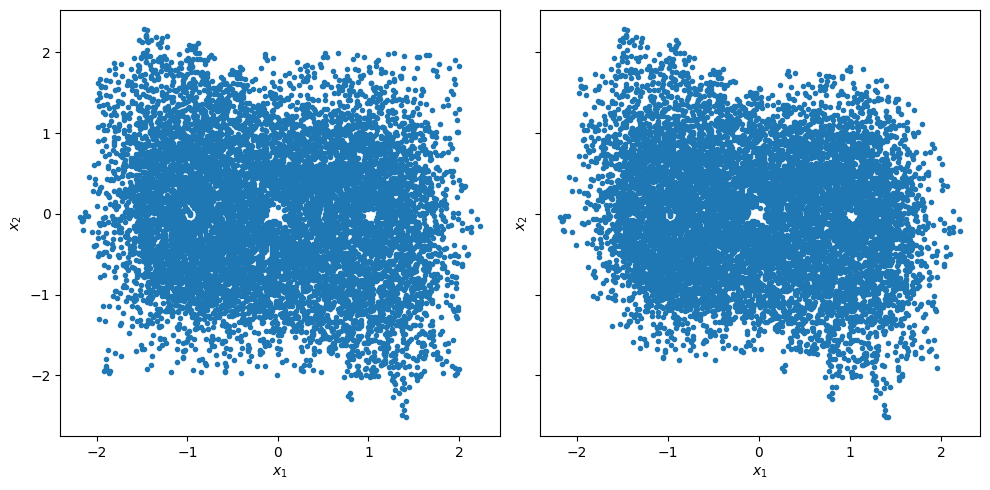

In [3]:
fig, (ax1,ax2) = plt.subplots(1,2,sharey=True, figsize=(10,5))
data_x_train = data_train.data()
ax1.plot(data_x_train[:,0], data_x_train[:,1], '.')
ax1.set_xlabel(r'$x_{1}$')
ax1.set_ylabel(r'$x_{2}$')
data_y_train = data_train.labels()
ax2.plot(data_y_train[:,0], data_y_train[:,1], '.')
ax2.set_xlabel(r'$x_{1}$')
ax2.set_ylabel(r'$x_{2}$')
plt.tight_layout()

Visualize validation data

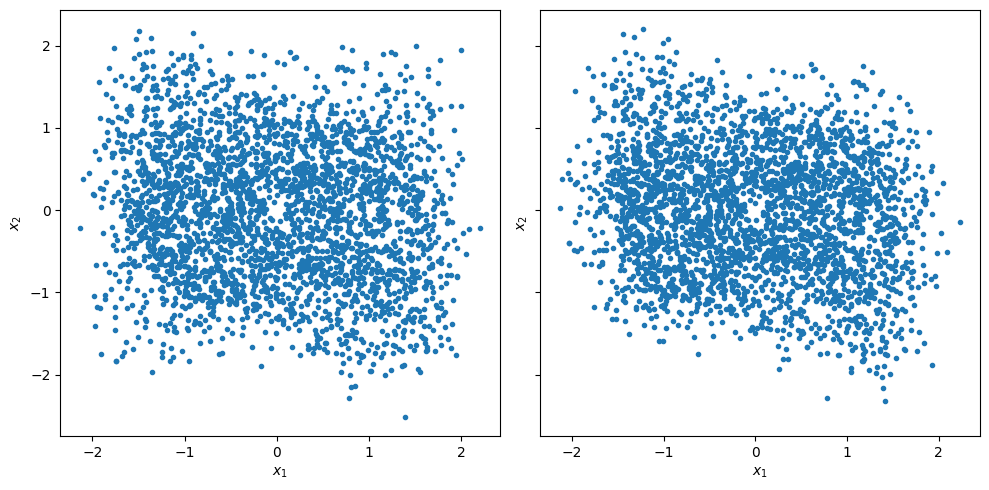

In [4]:
fig, (ax1,ax2) = plt.subplots(1,2,sharey=True, figsize=(10,5))
data_x_valid = data_valid.data()
ax1.plot(data_x_valid[:,0], data_x_valid[:,1], '.')
ax1.set_xlabel(r'$x_{1}$')
ax1.set_ylabel(r'$x_{2}$')
data_y_valid = data_valid.labels()
ax2.plot(data_y_valid[:,0], data_y_valid[:,1], '.')
ax2.set_xlabel(r'$x_{1}$')
ax2.set_ylabel(r'$x_{2}$')
plt.tight_layout()

Build up the solver

In [5]:
D = 2
M = 25
non_trainables = D + 1
hidden_layer_sizes = [100, 100, 100]
lr = 1e-4
reg = 0.1
reg_final = 0.01
n_epochs = 30
batch_size = 10000


net = kdl.TanhResNetWithNonTrainable(D, M, hidden_layer_sizes, non_trainables)
opt = torch.optim.Adam(net.parameters(), lr)
dic = kdl.TrainableDictionary(M, net, opt)
solver = kdl.EDMDDLSolver(dic, reg)
solver.solve(data_x_train, data_y_train, n_epochs, batch_size)
K = solver.compute_K(data_x_train, data_y_train, reg_final)
solver.compute_eig(K)

Training: 100%|██████████| 30/30 [00:06<00:00,  4.58it/s, loss=8.74e-05]


In [6]:
# save to file
model_path = kdl.root_dir + '/model/DuffingOscillator.pth'
# solver.save(model_path)
# solver.load(model_path)

## Plot the Eigenvalues

In [7]:
rbf_M = 100
rbf_regularizer = 1e-4
traj_len = 50

rbf_basis_func = kdl.RBFDictionary(rbf_M, rbf_regularizer)
rbf_basis_func.build(data_x_train)
rbf_solver = kdl.EDMDSolver(rbf_basis_func)
K = rbf_solver.compute_K(data_x_train, data_y_train)
rbf_solver.compute_eig(K)

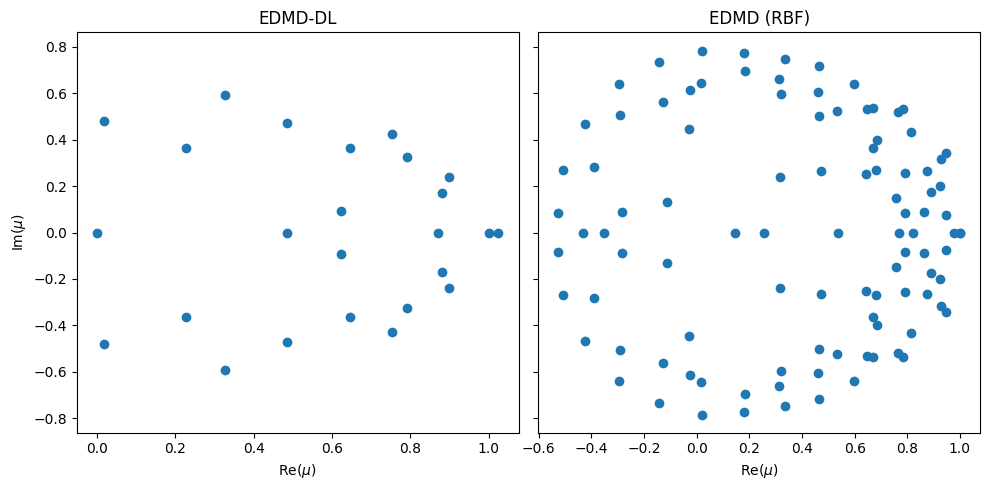

In [8]:
import numpy as np
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=True)
ax1.scatter(solver.eigenvalues.real,solver.eigenvalues.imag)
ax1.set_xlabel(r'Re$(\mu)$')
ax1.set_ylabel(r'Im$(\mu)$')
ax1.set_title('EDMD-DL')

ax2.scatter(rbf_solver.eigenvalues.real, rbf_solver.eigenvalues.imag)
ax2.set_xlabel(r'Re$(\mu)$')
ax2.set_title('EDMD (RBF)')

fig.tight_layout()

## Reconstruction

In [9]:
n_init = 1
traj_len = 50
seed = 111
traj_t_step = 0.25
x_min = -2
x_max = 2

data_x_test = flowmap.generate_traj_data(duffing, n_init, traj_len, traj_t_step, x_min, x_max, seed)
data_y_test = flowmap.generate_next_data(duffing, data_x_test, traj_t_step)
x_traj = data_x_test

x0_test = data_x_test[0].unsqueeze(0)
x_est_traj_DL = solver.predict(x0_test, traj_len)
x_est_traj_rbf = rbf_solver.predict(x0_test, traj_len)


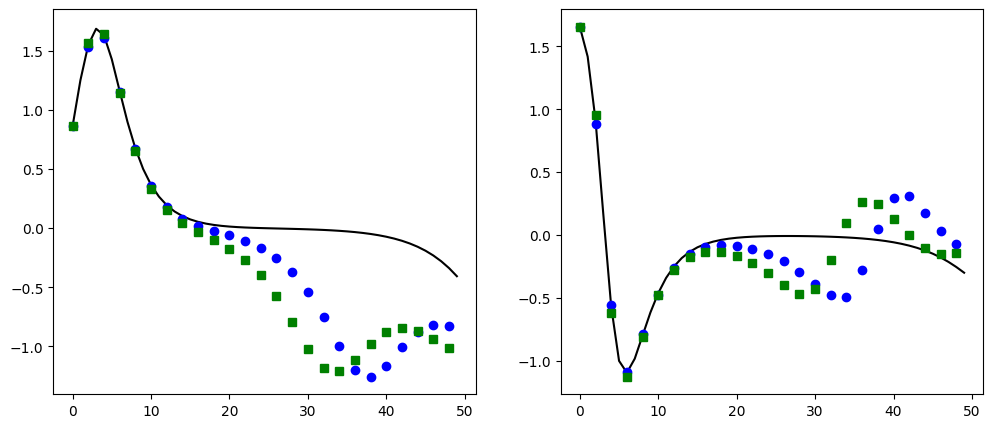

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(12,5))  

x_est_traj_DL = x_est_traj_DL.detach()
# Plot
t_grid = np.arange(0,traj_len)
ax1.plot(t_grid, x_traj[:,0], 'k-', label='Exact', markevery=2)
ax1.plot(t_grid, x_est_traj_DL[:,0], 'bo', label='EDMD-DL', markevery=2)
ax1.plot(t_grid, x_est_traj_rbf[:,0], 'gs', label='EDMD (RBF)', markevery=2)
    
ax2.plot(t_grid, x_traj[:,1], 'k-', label='Exact', markevery=2)
ax2.plot(t_grid, x_est_traj_DL[:,1], 'bo', label='EDMD-DL', markevery=2)
ax2.plot(t_grid, x_est_traj_rbf[:,1], 'gs', label='EDMD (RBF)', markevery=2)

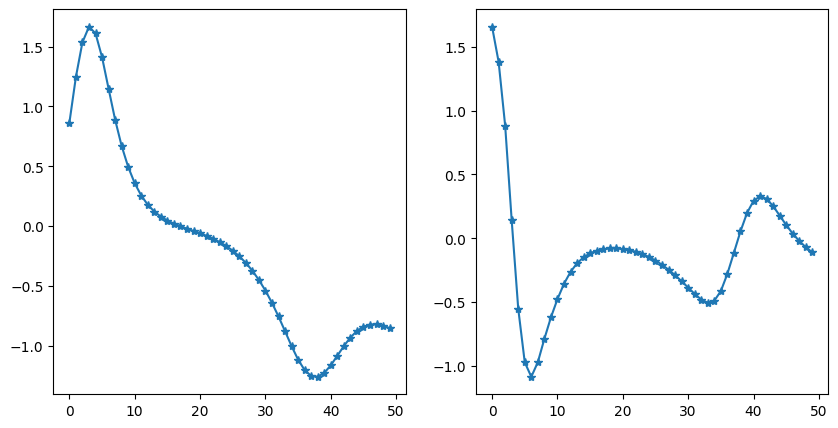

In [11]:

x_0 = torch.tensor([[0.8623, 1.6560]])
Predict = solver.predict(x_0,traj_len).detach().numpy()
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.plot(Predict[:,0],'-*')
# ax1.set_ylim([-1.25,-0.4])
ax2.plot(Predict[:,1],'-*')
# ax2.set_ylim([-0.45,0.85])